### 0. Get the Data

#### 0.1 Pass AWS Credentials and inspect the content of the bucket

In [1]:
import boto3
from botocore.exceptions import ClientError
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(dotenv_path='/Users/Bei/Documents/Bei/Zrive/zrive-ds/zrive_ds/src/module_2/passwords.env')

# Get the AWS credentials from environment variables
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')


client = boto3.client('s3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key)

bucket_name = 'zrive-ds-data'

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket_objects = []
for obj in bucket.objects.all():
    print(obj.key)
    bucket_objects.append(obj.key)

groceries/box_builder_dataset/feature_frame.csv
groceries/sampled-datasets/abandoned_carts.parquet
groceries/sampled-datasets/inventory.parquet
groceries/sampled-datasets/orders.parquet
groceries/sampled-datasets/regulars.parquet
groceries/sampled-datasets/users.parquet
groceries/trained-models/model.joblib


##### 0.2 Download the sampled datasets

In [7]:
parquet_files = [i for i in bucket_objects if i.endswith(".parquet")]

destination_dir = 'groceries_datasets'
os.makedirs(destination_dir, exist_ok=True)

for s3_path in parquet_files:
    # Get just the filename from the S3 path
    filename = s3_path.split('/')[-1]
    destination_file = os.path.join(destination_dir, filename)
    
    try:
        client.download_file(bucket_name, s3_path, destination_file)
        print(f"Downloaded '{s3_path}' from bucket '{bucket_name}' to '{destination_file}'")
    except ClientError as e:
        print(f"Error downloading '{s3_path}' from bucket '{bucket_name}': {e}")

Downloaded 'groceries/sampled-datasets/abandoned_carts.parquet' from bucket 'zrive-ds-data' to 'groceries_datasets/abandoned_carts.parquet'
Downloaded 'groceries/sampled-datasets/inventory.parquet' from bucket 'zrive-ds-data' to 'groceries_datasets/inventory.parquet'
Downloaded 'groceries/sampled-datasets/orders.parquet' from bucket 'zrive-ds-data' to 'groceries_datasets/orders.parquet'
Downloaded 'groceries/sampled-datasets/regulars.parquet' from bucket 'zrive-ds-data' to 'groceries_datasets/regulars.parquet'
Downloaded 'groceries/sampled-datasets/users.parquet' from bucket 'zrive-ds-data' to 'groceries_datasets/users.parquet'


### 1. Understanding the problem space

#### 1.1 Inspect Tables

##### 1.1.1 Inspect the Orders Table

In [263]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

file_path = "groceries_datasets/orders.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
orders = pd.read_parquet(file_path)

# Display the first few rows
display(orders.head())
orders.info()
orders.dtypes
orders.count()
orders.describe()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


,id,created_at,order_date,user_order_seq
count,8.773000e+03,8773,8773,8773.000000
mean,3.684684e+12,2021-08-22 03:54:18.750028,2021-08-21 12:47:21.262966,2.445116
min,2.204073e+12,2020-04-30 14:32:19,2020-04-30 00:00:00,1.000000
25%,3.690255e+12,2021-04-25 11:50:37,2021-04-25 00:00:00,1.000000
50%,3.846692e+12,2021-10-11 11:29:44,2021-10-11 00:00:00,1.000000
75%,3.945086e+12,2022-01-03 18:14:23,2022-01-03 00:00:00,3.000000
max,4.026732e+12,2022-03-14 00:24:59,2022-03-14 00:00:00,25.000000
std,4.145437e+11,NaN,NaN,2.707693


##### 1.1.2 Inspect the Abandoned Carts Table

In [6]:
# Specify the path to your parquet file
file_path = "groceries_datasets/abandoned_carts.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
abandoned_carts = pd.read_parquet(file_path)

# Display the first few rows
display(abandoned_carts.head())
abandoned_carts.info()
abandoned_carts.dtypes
abandoned_carts.count()
abandoned_carts.describe()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB


,id,created_at
count,5.457000e+03,5457
mean,2.161881e+13,2021-12-20 11:07:10.198460
min,1.285856e+13,2020-05-20 13:53:24
25%,2.133401e+13,2021-11-13 19:52:17
50%,2.167062e+13,2021-12-27 13:14:57
75%,2.192303e+13,2022-01-30 08:35:19
max,2.223385e+13,2022-03-13 14:12:10
std,4.028679e+11,NaN


##### 1.1.3 Inspect the Inventory Table

In [229]:
# Specify the path to your parquet file
file_path = "groceries_datasets/inventory.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
inventory = pd.read_parquet(file_path)

# Display the first few rows
display(inventory.head())
inventory.info()
inventory.dtypes
inventory.count()
inventory.describe()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


,variant_id,price,compare_at_price
count,1.733000e+03,1733.000000,1733.000000
mean,3.694880e+13,6.307351,7.028881
std,2.725674e+12,7.107218,7.660542
min,3.361529e+13,0.000000,0.000000
25%,3.427657e+13,2.490000,2.850000
50%,3.927260e+13,3.990000,4.490000
75%,3.948318e+13,7.490000,8.210000
max,4.016793e+13,59.990000,60.000000


##### 1.1.4 Inspect the Regulars Table

In [8]:
# Specify the path to your parquet file
file_path = "groceries_datasets/regulars.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
regulars = pd.read_parquet(file_path)

# Display the first few rows
display(regulars.head())
regulars.info()
regulars.dtypes
regulars.count()
regulars.describe()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


,variant_id,created_at
count,1.810500e+04,18105
mean,3.511989e+13,2021-08-15 02:27:30.703728
min,3.361527e+13,2020-04-30 13:09:27
25%,3.382643e+13,2021-03-21 10:41:42
50%,3.422171e+13,2021-10-16 09:11:26
75%,3.448855e+13,2022-01-14 22:35:14
max,4.013362e+13,2022-03-14 07:49:24
std,2.171237e+12,NaN


##### 1.1.5 Inspect the Users Table

In [132]:
# Specify the path to your parquet file
file_path = "groceries_datasets/users.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
users = pd.read_parquet(file_path)

# Display the first few rows
display(users.head())
users.info()
users.dtypes
users.count()
users.describe()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


,count_people,count_adults,count_children,count_babies,count_pets
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923
std,1.365753,0.869577,1.026246,0.289086,0.995603
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000


##### Groceries Dataset Schema:

To investigate/validate:
- Users table:
    - Investigate:
        - What does the poeple/adults/children/pets/babies mean, and how it works? why do they have the same number of nulls?
        - Column customer_cohort_month, what does it mean?
        - column user_nuts1, what does it mean? is it a categorical variable?
        - Column user_segment, what does it mean? is it a categorical variable?
    - Validate:
        - Are users only those who purchased an item or anyone who signed up?
            - Test: if there are users that do not have any purchase (first_ordered_at has NULLs) 
- Orders table:
    - Validate:
        - It looks like ordered_items is a list with the variant_id of the products purchased
            - Check that the items in ordered_items exists as variant_id

---

To do:
- In the case that ordered_items in the orders table and variant_id in abandoned_carts table are the product_ids, it would be easier to unnest those items so there is only one product per row.

- user_id is an object, it would be easier to manipulate if we converted it to a string.
    
- Investigate and validate hypotheses.
        
        
        
        
        
        
      

##### Users Table

What does the variable count_people mean?

In [165]:
users.head()


user_categories = users[['count_people','count_adults','count_children','count_babies','count_pets']]

user_categories_clean = user_categories.dropna(how='all')

try:
    user_categories_clean['count_people'].sum() == user_categories_clean['count_adults'].sum() + user_categories_clean['count_children'].sum() + user_categories_clean['count_babies'].sum()
    print('The variable count_people is the sum of adults, children and babies')
except:
    print("Don't know what count_people means")

The variable count_people is the sum of adults, children and babies


Variable  count_adults  count_babies  count_children  count_people  count_pets
Value                                                                         
0.0                  3           302             195             2         193
1.0                 71            21              55            57          87
2.0                201             2              58            97          28
3.0                 32             0              12            68           8
4.0                 11             0               3            67           6
5.0                  5             0               1            24           2
6.0                  1             0               1             8           1
7.0                  1             0               0             1           0
8.0                  0             0               0             1           0


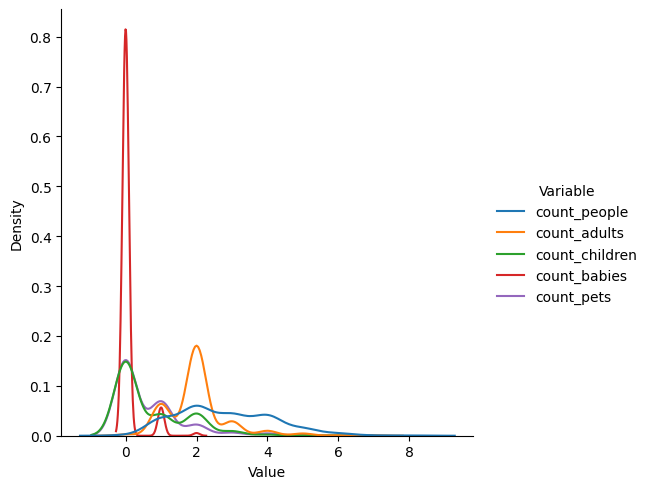

In [256]:
user_categories_clean.groupby(list(user_categories_clean.columns)).size().reset_index(name="count")

df_melted = user_categories_clean.melt(var_name='Variable', value_name='Value')

sns.displot(df_melted,x='Value',hue='Variable',kind='kde')

print(df_melted.pivot_table(index='Value', columns='Variable', aggfunc='size', fill_value=0))

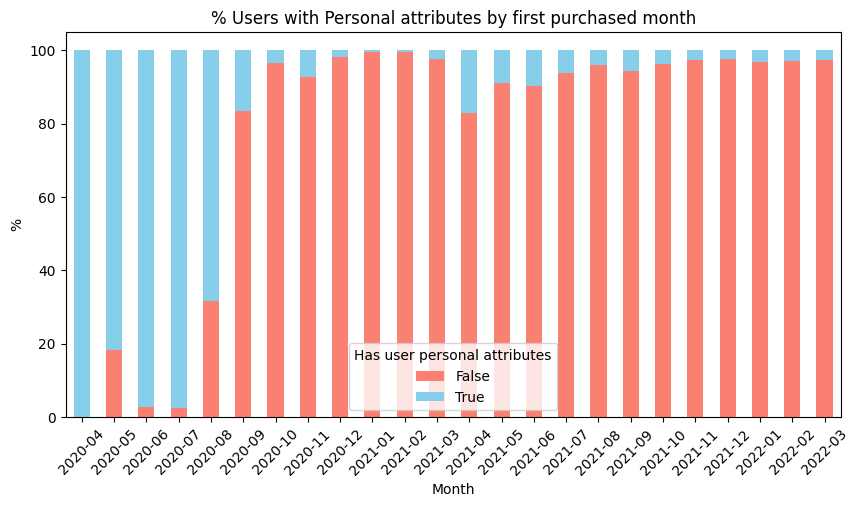

In [268]:
users['has_personal_attributes'] = np.where(users['count_people'].isnull(),False,True)
users['year_month'] = users['first_ordered_at_trunc'].dt.to_period('M')

#  Extract year-month

monthly_counts = users.groupby(['year_month', 'has_personal_attributes']).size().unstack(fill_value=0)

# Convert to percentage (normalize)
monthly_percentage = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# Plot
monthly_percentage.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 5))

# Customize plot
plt.title('% Users with Personal attributes by first purchased month')
plt.ylabel('%')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(['False', 'True'], title="Has user personal attributes")
plt.show()


What does customer_cohort_month?

In [166]:
#truncate first order date to month
users['first_ordered_at_trunc'] = pd.to_datetime(users['first_ordered_at']).dt.to_period("M").dt.to_timestamp()

users['customer_cohort_month'] = pd.to_datetime(users['customer_cohort_month']).dt.to_period("M").dt.to_timestamp()


users["is_customer_cohort_first_order"] = users['first_ordered_at_trunc'] == users['customer_cohort_month']


print(users['is_customer_cohort_first_order'].value_counts())


print(users[["first_ordered_at","first_ordered_at_trunc","customer_cohort_month"]][users["is_customer_cohort_first_order"] == False])



is_customer_cohort_first_order
True     4982
False       1
Name: count, dtype: int64
         first_ordered_at first_ordered_at_trunc customer_cohort_month
3699  2020-10-01 00:37:56             2020-10-01            2020-09-01


The column customer_cohort_month is a user cohort truncated by the month in which the user made the first purchase. There is an exception in one record, which might indicate the the timezone on the first_ordered_at column might be different than what it was used for the customer_cohort_month

In [167]:
print(users['user_nuts1'].value_counts())


user_nuts1
UKI    1318
UKJ     745
UKK     602
UKH     414
UKD     358
UKM     315
UKE     303
UKG     295
UKF     252
UKL     224
UKC     102
UKN       4
Name: count, dtype: int64


The variable user_nuts1 is a categorical variable that indicates a geographical zone from the UK.

In [ ]:
# get the number of items ordered within the same order
orders['ordered_items_sum'] = orders['ordered_items'].apply(len)

# get the number of times a user ordered in total
user_orders = orders.groupby("user_id")["id"].count().reset_index()
user_orders.columns = ["user_id", "order_count"] 

# get the number of items a user ordered in total
user_items_sum = orders.groupby("user_id")["ordered_items_sum"].sum().reset_index()
user_items_sum.columns = ["user_id", "total_items_ordered"]

# join the orders and number of items
user_orders_and_items = pd.merge( user_orders,user_items_sum, how='left', on='user_id')

# join the user segment with the orders data
user_segments_w_orders = pd.merge(users[['user_id','user_segment']],user_orders_and_items,how='left',on='user_id')


analysis = user_segments_w_orders.groupby("user_segment").agg({
    'order_count': ['count', 'mean', 'min', 'max', 'sum'],
    'total_items_ordered': ['mean', 'min', 'max', 'sum']
})

analysis

order_count                         total_items_ordered           \
                   count      mean min max   sum                mean min  max   
user_segment                                                                    
Proposition         2340  1.785043   1  22  4177           27.937179   7  499   
Top Up              2643  1.738933   1  25  4596           16.112372   1  389   

                     
                sum  
user_segment         
Proposition   65373  
Top Up        42585

It doesn't look like there is any correlation between the number of orders or the number of items ordered for the user_segment variable. A possible explanation for the segment meaning is in the products they purchased.

In [269]:
added_to_regulars = regulars.groupby('user_id')['created_at'].min()

users_w_regulars = pd.merge(user_segments_w_orders,added_to_regulars,how='left',on='user_id')


result = users_w_regulars.groupby('user_segment')['created_at'].agg([
    ('added_products_to_regulars', lambda x: x.isna().sum()),
    ('not_added_products_to_regulars', lambda x: x.notna().sum())
])

print(result)

              added_products_to_regulars  not_added_products_to_regulars
user_segment                                                            
Proposition                         1556                             784
Top Up                              1979                             664


It does not look like there is a correlation between the user_segment and the user having added an item to their regulars

In [169]:
if users['first_ordered_at'].isna().sum()==0:
    print("All users are paying customers") 
else:
    print("There are users that just registered")

All users are paying customers


#### Orders

In [245]:
# get only the necessary columns
ordered_items = orders[['order_date','ordered_items']]

# unnest the list of items
ordered_items= ordered_items.explode('ordered_items')


# get the first, last and number of purchases for a given item
orders_agg = ordered_items.groupby('ordered_items').agg({
    'order_date':['min','max','count']
}).reset_index()

# rename the columns
orders_agg.columns =['variant_id','first_ordered','last_ordered','no_times_ordered']

ordered_products = pd.merge(orders_agg,inventory, how='left',on='variant_id')

ordered_products['has_price'] = np.where(ordered_products['price'].isnull(),False,True)

ordered_products.head()


,variant_id,first_ordered,last_ordered,no_times_ordered,price,compare_at_price,vendor,product_type,tags,has_price
0,33615294398596,2020-10-24,2022-03-10,88,2.99,3.0,hollings,dog-food,[dog-treats],True
1,33618830196868,2020-05-01,2020-05-01,1,NaN,NaN,NaN,NaN,NaN,False
2,33618835243140,2020-04-30,2020-04-30,1,NaN,NaN,NaN,NaN,NaN,False
3,33618835964036,2020-04-30,2020-04-30,1,NaN,NaN,NaN,NaN,NaN,False
4,33618846580868,2020-05-01,2020-05-01,1,NaN,NaN,NaN,NaN,NaN,False


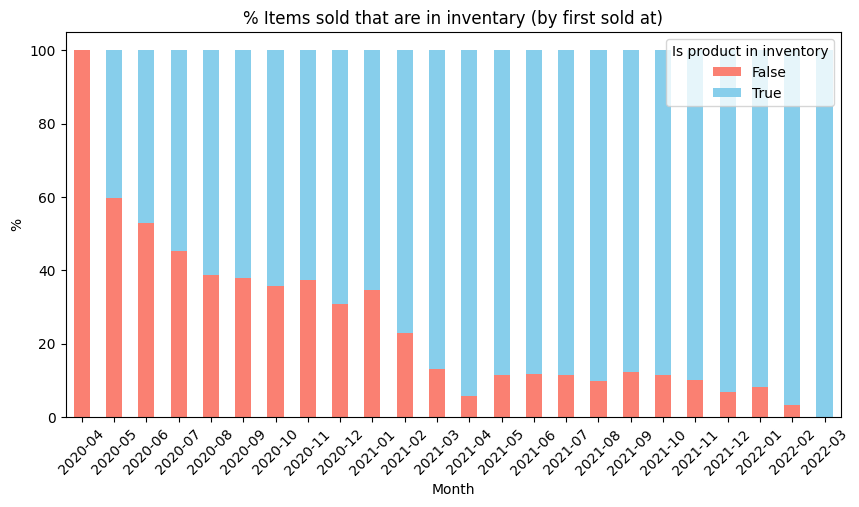

In [255]:

#  Extract year-month
ordered_products['year_month'] = ordered_products['first_ordered'].dt.to_period('M')

monthly_counts = ordered_products.groupby(['year_month', 'has_price']).size().unstack(fill_value=0)

# Convert to percentage (normalize)
monthly_percentage = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# Plot
monthly_percentage.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 5))

# Customize plot
plt.title('% Items sold that are in inventary (by first sold at)')
plt.ylabel('%')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(['False', 'True'], title="Is product in inventory")
plt.show()

We do not have inventory details for some products. For products sold before 2021, the % of products where we do not have invontry data is around 50%, from 2021 onwards that drops dramatically to around 20%.

What we know:

- We have a dataset from an ecommerce site with the following schema:

![alt text](groceries_schema.png "Groceries Schema")


---

We know that users have not just signed up but they must have purchased a product to qualify as users. 

We have segmented them:
- by when they made their first purchase (Monthly cohort).
- by their household characteristics: number of people and type (individual, couple, childs/pets). This data might not be reliable because most of this data is from 04/2020 - 08/2020 cohorts.
- UK geographical zone.
- User segment (Top Up/ Proposition), we do not know how this segmentation is done. We know it is not based on the number of orders, the number of items per order, or adding items to regulars.


Regarding orders, we have missing data for products description and pricing that started being sold in 2020. 
